Here we open the json data and normalize the data such that each row corresponds to one ingredient.

The dataset has already been parsed by a CRF model to turn the freeform recipe ingredients into structured data (name, unit, quantity).

In [6]:
import pandas as pd
import json

with open('enriched_recipes.json') as f:
    data = json.load(f)
    df = pd.json_normalize(
        data, 'parsed_ingredients',
        meta=['author',
              'photo_url',
              'prep_time_minutes',
              'rating_stars',
              'review_count',
              'title',
              'total_time_minutes',
              'url'
             ],
        record_prefix='ingredient_', errors='ignore')

The output data looks like this:

In [7]:
df

,ingredient_comment,ingredient_input,ingredient_name,ingredient_other,ingredient_qty,ingredient_unit,ingredient_range_end,author,photo_url,prep_time_minutes,rating_stars,review_count,title,total_time_minutes,url
0,chilled and cubed,"1/2 cup unsalted butter, chilled and cubed",unsalted butter,",",1/2,cup,NaN,Stephanie,http://images.media-allrecipes.com/userphotos/...,55,4.32,46,"Basil, Roasted Peppers and Monterey Jack Cornb...",100,http://allrecipes.com/Recipe/6664/
1,chopped,1 cup chopped onion,onion,NaN,1,cup,NaN,Stephanie,http://images.media-allrecipes.com/userphotos/...,55,4.32,46,"Basil, Roasted Peppers and Monterey Jack Cornb...",100,http://allrecipes.com/Recipe/6664/
2,NaN,1 3/4 cups cornmeal,cornmeal,NaN,1 3/4,cup,NaN,Stephanie,http://images.media-allrecipes.com/userphotos/...,55,4.32,46,"Basil, Roasted Peppers and Monterey Jack Cornb...",100,http://allrecipes.com/Recipe/6664/
3,NaN,1 1/4 cups all-purpose flour,all-purpose flour,NaN,1 1/4,cup,NaN,Stephanie,http://images.media-allrecipes.com/userphotos/...,55,4.32,46,"Basil, Roasted Peppers and Monterey Jack Cornb...",100,http://allrecipes.com/Recipe/6664/
4,NaN,1/4 cup white sugar,white sugar,NaN,1/4,cup,NaN,Stephanie,http://images.media-allrecipes.com/userphotos/...,55,4.32,46,"Basil, Roasted Peppers and Monterey Jack Cornb...",100,http://allrecipes.com/Recipe/6664/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836531,NaN,2 tablespoons brown sugar,brown sugar,NaN,2,tablespoon,NaN,larkspur,http://images.media-allrecipes.com/global/reci...,32,0.0,0,Blueberry Oatmeal Cream Brulee,44,http://allrecipes.com/Recipe/258791/
836532,NaN,2 tablespoons maple syrup,maple syrup,NaN,2,tablespoon,NaN,larkspur,http://images.media-allrecipes.com/global/reci...,32,0.0,0,Blueberry Oatmeal Cream Brulee,44,http://allrecipes.com/Recipe/258791/
836533,NaN,2 tablespoons butter,butter,NaN,2,tablespoon,NaN,larkspur,http://images.media-allrecipes.com/global/reci...,32,0.0,0,Blueberry Oatmeal Cream Brulee,44,http://allrecipes.com/Recipe/258791/
836534,NaN,1 cup blueberries,blueberries,NaN,1,cup,NaN,larkspur,http://images.media-allrecipes.com/global/reci...,32,0.0,0,Blueberry Oatmeal Cream Brulee,44,http://allrecipes.com/Recipe/258791/


Filter the data where recipe ratings are valid (more than 20 reviews and more than 0 stars).

Then, group the ingredients by ingredient name, and average each ingredient's numerical rating.

In [8]:
grouped = df.where(df['rating_stars'] > 0).where(df['review_count'] > 20).groupby("ingredient_name").agg(avg_rating=("rating_stars", "mean")).reset_index()

grouped

,ingredient_name,avg_rating
0,(.13 ounce) envelope unsweetened grape soft dr...,4.400000
1,(.13 ounce) envelope unsweetened orange soft d...,4.400000
2,(.14 ounce) package sugar free instant lemonad...,4.490000
3,(.18 ounce) packet sazon seasoning,4.520000
4,(.25 ounce) envelope active dry yeast,4.471250
...,...,...
9292,zucchini chunks,4.560000
9293,zucchini matchsticks,4.540000
9294,zucchini squash,4.454000
9295,zucchini squashes,4.260000


In [9]:
pd.set_option('display.max_rows', 1000)

df["ingredient_name"] = df["ingredient_name"].str.lower()

df["ingredient_name"].value_counts().head(1000)


salt                                                             33821
butter                                                           24428
water                                                            19731
all-purpose flour                                                18193
garlic                                                           18066
onion                                                            16757
white sugar                                                      16544
eggs                                                             14806
olive oil                                                        13856
milk                                                             12072
vanilla extract                                                  11438
black pepper                                                     11092
egg                                                              10895
sugar                                                             9583
brown 

In [10]:
name_cleaning_map = {
    "egg": "eggs",
    "tomato": "tomatoes",
    "all-purpose flour": "flour",
    "sugar": "white sugar",
    "salt and black pepper": "salt and pepper",
    "carrot": "carrots",
    "basil leaves": "basil"
}

df["ingredient_name"] = df["ingredient_name"].apply(
    lambda name: name_cleaning_map.get(name, name))

df["ingredient_name"].value_counts().head(1000)

salt                                                             33821
white sugar                                                      26127
eggs                                                             25701
butter                                                           24428
water                                                            19731
flour                                                            19531
garlic                                                           18066
onion                                                            16757
olive oil                                                        13856
milk                                                             12072
vanilla extract                                                  11438
black pepper                                                     11092
salt and pepper                                                   9983
brown sugar                                                       9317
vegeta

In [11]:
spices = [
    'allspice',
    'angelica',
    'anise',
    'asafoetida',
    'bay leaf',
    'basil',
    'bergamot',
    'black cumin',
    'black mustard',
    'black pepper',
    'borage',
    'brown mustard',
    'burnet',
    'caraway',
    'cardamom',
    'cassia',
    'catnip',
    'cayenne pepper',
    'celery seed',
    'chervil',
    'chicory',
    'chili pepper',
    'chives',
    'cicely',
    'cilantro',
    'cinnamon',
    'clove',
    'coriander',
    'costmary',
    'cumin',
    'curry',
    'dill',
    'fennel',
    'fenugreek',
    'filé',
    'garlic powder',
    'ginger',
    'grains of paradise',
    'holy basil',
    'horehound',
    'horseradish',
    'hyssop',
    'lavender',
    'lemon balm',
    'lemon grass',
    'lemon verbena',
    'licorice',
    'lovage',
    'mace',
    'marjoram',
    'nutmeg',
    'oregano',
    'onion powder',
    'paprika',
    'parsley',
    'peppermint',
    'poppy seed',
    'rosemary',
    'rue',
    'saffron',
    'sage',
    'savory',
    'sesame',
    'sorrel',
    'star anise',
    'spearmint',
    'tarragon',
    'thyme',
    'tumeric',
    'vanilla',
    'wasabi',
    'white mustard'
]

In [12]:
spices_regex = r"|".join(spices)
df['ingredient_name'].value_counts()[:110]

salt                    33821
white sugar             26127
eggs                    25701
butter                  24428
water                   19731
flour                   19531
garlic                  18066
onion                   16757
olive oil               13856
milk                    12072
vanilla extract         11438
black pepper            11092
salt and pepper          9983
brown sugar              9317
vegetable oil            9020
cinnamon                 8517
tomatoes                 7434
lemon juice              7079
baking powder            6629
baking soda              6070
parsley                  5318
parmesan cheese          5123
cheddar cheese           5009
carrots                  5002
sour cream               4603
pepper                   4482
basil                    4472
celery                   4446
garlic powder            4289
chicken broth            4199
confectioners' sugar     4089
cream cheese             3963
beef                     3936
soy sauce 

In [13]:
recipes_with_spices = df.loc[df['ingredient_name'].str.contains(spices_regex).fillna(False)]

replace_dict = {}

for spice in spices:
    replace_dict[f".*{spice}.*"] = spice

recipes_with_spices['spice'] = recipes_with_spices['ingredient_name'].replace(replace_dict, regex=True)

/tmp/ipykernel_5899/1310573300.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes_with_spices['spice'] = recipes_with_spices['ingredient_name'].replace(replace_dict, regex=True)


In [14]:
common_spices = set(recipes_with_spices['spice'].value_counts().head(20).index)
recipes_with_spices['spice'].value_counts()

vanilla           14990
black pepper      12517
cinnamon           9323
parsley            6578
ginger             5402
basil              5045
garlic powder      4395
cilantro           4126
nutmeg             3784
cumin              3696
sage               3633
oregano            3618
thyme              3491
cayenne pepper     3126
paprika            3059
clove              2382
sesame             2363
dill               1930
rosemary           1912
curry              1502
onion powder       1378
allspice           1142
chives             1043
bay leaf            995
coriander           882
tarragon            696
fennel              576
horseradish         574
cardamom            556
celery seed         430
marjoram            425
poppy seed          387
peppermint          344
anise               316
caraway             282
brown mustard       220
saffron             217
savory              183
mace                131
wasabi              112
lemon grass          88
chili pepper    

In [15]:
spices_count = recipes_with_spices.groupby(
    "url", as_index=False
).agg(
    spices_count=("spice", "count"), url=("url", "first")
)

spices_count
recipes_with_spices
recipes_with_spices_with_count = recipes_with_spices.merge(
    spices_count, on="url"
)

multi_spice_recipes = recipes_with_spices_with_count.loc[
    recipes_with_spices_with_count["spices_count"] > 1
]

common_multi_spice_recipes = multi_spice_recipes[multi_spice_recipes['spice'].isin(common_spices)]

dummy = pd.get_dummies(
    common_multi_spice_recipes,
    columns=["spice"],
    prefix='',
    prefix_sep=''
).groupby(['url'], as_index=False).max()
dummy

/tmp/ipykernel_5899/545595348.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ).groupby(['url'], as_index=False).max()


,url,ingredient_input,ingredient_name,ingredient_range_end,author,photo_url,prep_time_minutes,rating_stars,review_count,title,...,ginger,nutmeg,oregano,paprika,parsley,rosemary,sage,sesame,thyme,vanilla
0,http://allrecipes.com/Recipe/10000/,1 1/2 teaspoons vanilla extract,vanilla extract,NaN,Lisa Lepsy,http://images.media-allrecipes.com/userphotos/...,8,3.86,39,Chocolate Sandwich Cookies I,...,0,0,0,0,0,0,0,0,0,1
1,http://allrecipes.com/Recipe/100033/,3/4 cup clover honey,vanilla extract,NaN,Mrs. Michael Ramey,http://images.media-allrecipes.com/userphotos/...,0,4.33,9,Honey-Cocoa Frosting,...,0,0,0,0,0,0,0,0,0,1
2,http://allrecipes.com/Recipe/10006/,1 teaspoon vanilla extract,vanilla extract,NaN,Starr Tharp,http://images.media-allrecipes.com/userphotos/...,0,4.00,6,Starr's Soft Sugar Cookies,...,0,1,0,0,0,0,0,0,0,1
3,http://allrecipes.com/Recipe/100061/,8 (4 ounce) links Italian sausage,sausage,NaN,Pam Anderson,http://images.media-allrecipes.com/userphotos/...,60,3.33,3,Pam's Red Sauce with Meatballs and Sausage,...,0,0,0,0,1,0,1,0,0,0
4,http://allrecipes.com/Recipe/10010/,1 teaspoon vanilla extract,vanilla extract,NaN,Ceil Wallace,http://images.media-allrecipes.com/userphotos/...,0,4.63,28,Toasted Oats Cookies,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27616,http://allrecipes.com/Recipe/99853/,"2 sprigs fresh basil, chopped",rosemary,NaN,REINEJESSICA,http://images.media-allrecipes.com/userphotos/...,16,4.51,33,Basil Goat Cheese Pizza,...,0,0,0,0,0,1,0,0,0,0
27617,http://allrecipes.com/Recipe/9987/,1 teaspoon vanilla extract,vanilla extract,NaN,Sabrina Shaw,http://images.media-allrecipes.com/userphotos/...,0,4.38,21,Vanishing Chocolate Oatmeal Cookies,...,0,0,0,0,0,0,0,0,0,1
27618,http://allrecipes.com/Recipe/99870/,Curry Paste,ginger paste,NaN,Lee Jackson,http://images.media-allrecipes.com/userphotos/...,120,4.57,35,Lamb Madras Curry,...,1,0,0,0,0,0,0,0,0,0
27619,http://allrecipes.com/Recipe/99915/,2 tablespoons minced fresh parsley,thyme,NaN,Brandee,http://images.media-allrecipes.com/userphotos/...,35,4.14,67,Crab Stuffed Manicotti,...,0,0,0,0,1,0,0,0,1,0


In [16]:
spice_corr = dummy.drop(columns=multi_spice_recipes.columns, errors="ignore")
corr = spice_corr.corr()

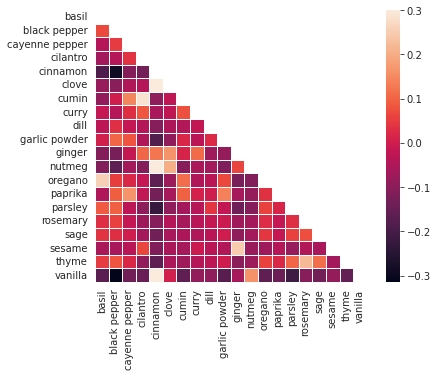

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 15]

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(7, 5))
    ax.tick_params(axis='x', labelrotation=45)

    sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5)



In [18]:
# units = df["ingredient_unit"].value_counts().rename_axis(
#        'ingredient_unit'
# ).reset_index(name='unit_counts').head(10)

# NUM_INGREDIENTS_PER_BAR = 5

# joined = df.merge(units, how="inner", on="ingredient_unit")
# top_ingredients_by_unit = joined.groupby(
#        ["ingredient_unit", "ingredient_name"]
# ).agg(
#        name_count=("ingredient_name", "count"),
#        unit_count=("unit_counts", "first")
# ).groupby(
#        'ingredient_unit', as_index=False
# ).apply(lambda x: x.nlargest(NUM_INGREDIENTS_PER_BAR, 'name_count'))

# new = top_ingredients_by_unit.assign(
#        ingredient_freq=top_ingredients_by_unit["name_count"] / top_ingredients_by_unit["unit_count"]
# )

# # print(new)

# new.reset_index(inplace=True)

# # print(units["ingredient_unit"])



# NUM_UNITS = len(units["ingredient_unit"])

# print(NUM_INGREDIENTS_PER_BAR, NUM_UNITS)

# values = [[0 for x in range(NUM_UNITS)] for y in range(NUM_INGREDIENTS_PER_BAR)]
# labels = [[0 for x in range(NUM_UNITS)] for y in range(NUM_INGREDIENTS_PER_BAR)]
# unit_labels = []

# print("test")

# # a list the length of the number of units
# # where each element is a list the length of the
# # top N ingredients for that unit

# # unit = "cup"

# print(new.loc[new["ingredient_unit"] == "cup"]["ingredient_freq"].iloc[0])

# print("test2")
# for unit_idx, unit in enumerate(units["ingredient_unit"]):
#        unit_labels.append(unit)
#        for i in range(NUM_INGREDIENTS_PER_BAR):
#               print(unit, i)
#               values[i][unit_idx] = new.loc[new["ingredient_unit"] == unit]["ingredient_freq"].iloc[i]
#               labels[i][unit_idx] = new.loc[new["ingredient_unit"] == unit]["ingredient_name"].iloc[i]

# print(values)
# print(labels)

# # reference:
# # https://seaborn.pydata.org/examples/part_whole_bars.html

# # TODO: break this down by ingredient
# f, ax = plt.subplots(figsize=(6, 15))

# import random


# ypos = range(NUM_UNITS)

# left = [0] * NUM_UNITS

# for i in range(NUM_INGREDIENTS_PER_BAR):
#        ax.barh(
#               ypos,
#               values[i],
#               left=left,
#               height=0.7,
#               color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(100)],
#               label=labels[i]
#        )

#        left = values[i]

# # regular graph
# # sns.barplot(x="ingredient_unit", y="unit_counts", data=units,
# #        label="Alcohol-involved", color="b")
# plt.legend()
# plt.show()


In [104]:
import networkx as nx

ingredient_count = df.groupby(
    "ingredient_name"
).agg(
    ingredient_count=("ingredient_name", "count")
).nlargest(100, columns=["ingredient_count"])

print(len(df["url"].unique()))

ingredient_count.reset_index(inplace=True)

common_ingredients = set(ingredient_count["ingredient_name"])

common_subset = df.loc[df["ingredient_name"].isin(common_ingredients)][
    ["url", "ingredient_name", "rating_stars", "review_count", "title"]
]


91458


In [105]:
common_subset_2 = common_subset.copy()

merged = common_subset.merge(common_subset_2, on="url")
merged_without_same = merged.loc[merged["ingredient_name_x"] < merged["ingredient_name_y"]]

merged_without_same["edge"] = list(zip(
    merged_without_same["ingredient_name_x"],
    merged_without_same["ingredient_name_y"]))

weights = merged_without_same.groupby("edge").agg(
    edge_weight=("edge", "count"),
    urls=("url", set),
    edge=("edge", "first"),
    ingredient_x=("ingredient_name_x", "first"),
    ingredient_y=("ingredient_name_y", "first"),
)

# test = weights.sort_values('edge_weight', ascending = False).groupby("ingredient_x")['edge_weight'].head(3)

top_3_edges = weights.groupby("ingredient_x").apply(lambda grp: grp.nlargest(3, 'edge_weight'))["ingredient_y"]
weights = pd.merge(top_3_edges, weights, on=["ingredient_x", "ingredient_y"])

weights["edge_weight_normalized"] = weights["edge_weight"] / weights["edge_weight"].max()

weight_tuples = list(zip(
    weights["ingredient_x"],
    weights["ingredient_y"],
    weights["edge_weight_normalized"]))

weights

/tmp/ipykernel_5899/283366299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_without_same["edge"] = list(zip(


,ingredient_x,ingredient_y,edge_weight,urls,edge,edge_weight_normalized
0,almonds,white sugar,1141,"{http://allrecipes.com/Recipe/123863/, http://...","(almonds, white sugar)",0.068099
1,almonds,salt,950,"{http://allrecipes.com/Recipe/236340/, http://...","(almonds, salt)",0.056699
2,almonds,eggs,903,"{http://allrecipes.com/Recipe/212369/, http://...","(almonds, eggs)",0.053894
3,apples,white sugar,871,"{http://allrecipes.com/Recipe/244426/, http://...","(apples, white sugar)",0.051984
4,apples,cinnamon,839,"{http://allrecipes.com/Recipe/232486/, http://...","(apples, cinnamon)",0.050075
5,apples,butter,657,"{http://allrecipes.com/Recipe/124843/, http://...","(apples, butter)",0.039212
6,bacon,onion,909,"{http://allrecipes.com/Recipe/13251/, http://a...","(bacon, onion)",0.054252
7,bacon,salt,824,"{http://allrecipes.com/Recipe/16558/, http://a...","(bacon, salt)",0.049179
8,bacon,eggs,623,"{http://allrecipes.com/Recipe/231986/, http://...","(bacon, eggs)",0.037183
9,baking powder,flour,6031,"{http://allrecipes.com/Recipe/9765/, http://al...","(baking powder, flour)",0.359952


294


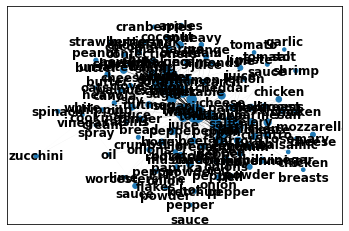

In [106]:
# plot the graph with networkx
G = nx.Graph()
G.add_nodes_from(common_ingredients)

G.add_weighted_edges_from(weight_tuples)

edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

pos = nx.spring_layout(G, iterations=50, seed=9)

node_size=[ingredient_count.loc[
    ingredient_count["ingredient_name"] == n
]["ingredient_count"] / 100 for n in G.nodes()]

nodenames = {n: n.replace(" ", "\n") for n in G.nodes()}

print(len(G.edges()))
plt.grid(False)

nx.draw_networkx_nodes(G, pos, node_size=node_size)
nx.draw_networkx_labels(G, pos, labels=nodenames, font_weight="bold")
nx.draw_networkx_edges(G, pos, width=edgewidth,)

In [107]:
weight_tuples = zip(
    weights["ingredient_x"],
    weights["ingredient_y"],
    weights["edge_weight_normalized"],
    weights["edge_weight"])


best_per_ingredient = common_subset.where(
    common_subset['review_count'] > 50
).sort_values('rating_stars').drop_duplicates('ingredient_name',keep='last')

d3_format = {
    "nodes": [{"size": float(ingredient_count.loc[
                    ingredient_count["ingredient_name"] == n
                ]["ingredient_count"]),
                "id": n,
                "best_recipe": {
                    "title": str(best_per_ingredient.loc[
                        best_per_ingredient["ingredient_name"] == n
                    ]["title"].item()),
                    "url": str(best_per_ingredient.loc[
                        best_per_ingredient["ingredient_name"] == n
                    ]["url"].item())
                }
            } for n in common_ingredients],
    "links": [ {
        "source": u,
        "target": v,
        "value": d,
        "count": c
    } for (u,v,d,c) in weight_tuples]
}

with open("d3_graph.json", "w") as f:
    json.dump(d3_format, f)

<AxesSubplot:xlabel='quantity_tablespoons', ylabel='rating_stars'>

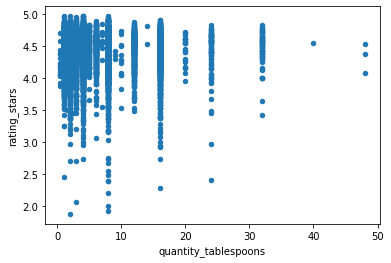

In [109]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

butter_recipes = df.loc[df["ingredient_name"].isin(["butter"])]

butter_recipes = butter_recipes[butter_recipes['ingredient_qty'].notnull()]


# only look at recipes with at least 10 reviews
butter_recipes = butter_recipes[butter_recipes['review_count'] >= 20]

butter_recipes["quantity_float"] = butter_recipes["ingredient_qty"].apply(convert_to_float)

butter_recipes = butter_recipes.loc[
    butter_recipes["ingredient_unit"
].isin(["cup", "tablespoon"])]

butter_recipes.loc[
    butter_recipes["ingredient_unit"] == "cup", 'quantity_tablespoons'
] = butter_recipes['quantity_float'] * 16

butter_recipes.loc[
    butter_recipes["ingredient_unit"] == "tablespoon", 'quantity_tablespoons'
] = butter_recipes['quantity_float']


# filter outliers
butter_recipes = butter_recipes[butter_recipes['quantity_tablespoons'] < 100]

# print(butter_recipes.nlargest(1, columns=["quantity_tablespoons"]))

# final = butter_recipes.groupby("quantity_tablespoons").agg(
#     avg_rating=("rating_stars", "mean"),
#     quantity_tablespoons=("quantity_tablespoons", "first")
# )
# print(final["quantity_tablespoons"].corr(final["avg_rating"]))

butter_recipes.plot.scatter(x="quantity_tablespoons", y="rating_stars")


10673


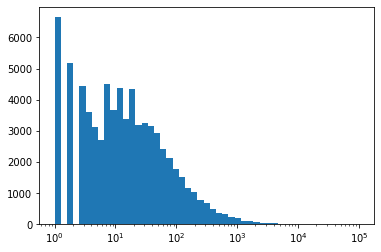

In [126]:
import pylab as pl
import numpy as np

review_count_by_url = df.groupby(
    'url'
).agg(
    review_count=("review_count", "first")
)["review_count"]

print(review_count_by_url.max())

MIN, MAX = 1, 10000.0

pl.figure()
pl.hist(review_count_by_url, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50))
pl.gca().set_xscale("log")
pl.show()